In [89]:
using BenchmarkTools
using Combinatorics

include("../phase1/node.jl")
include("../phase1/edges.jl")
include("../phase1/graph.jl")
include("../phase1/read_stsp.jl")
include("../phase2/comp_connexes.jl")
include("../phase1/main.jl")
include("../phase2/queue.jl")
include("../phase2/heuristics.jl")
include("../phase2/Kruskal.jl")
include("../phase2/prims_algorithm.jl")
include("../phase3/hk.jl")
include("../phase3/rsl.jl")

optimal_rsl (generic function with 1 method)

## Algorithme de Rosenkrantz, Stearns et Lewis
Dans l'algorithme RSL, on doit parcourir l'arbre obtenu en préordre. Nous avons donc implémenté une fonction qui parcours l'arbre et qui renvoie la liste des noeuds dans l'ordre visité

In [90]:
""" Parcours un arbre en préordre et retourne la liste des noeuds dans l'ordre dans lequel ils ont été visités."""
function parcours_preordre(tree, racine)
    current_node = racine
    parcours_liste = [] #Contient l'ordre dans lequel les noeuds sont visités
    completed_nodes = [] #Contient tous les noeuds dont tous les enfants ont été visités
    i = 1
    while true
        change = false
        if !(current_node in parcours_liste) #Si le noeud n'a pas encore été visité
            push!(parcours_liste, current_node)  #On l'ajoute à l'ordre de visite
        end

        for child in children(tree, current_node)
            if !(child in parcours_liste) #Si l'enfant n'a pas encore été visité
                current_node = child #Il sera le prochain noeud visité
                change = true
                break
            end
        end

        if change == false  #Si le noeud n'a aucun enfant qui n'a pas encore été visité
            push!(completed_nodes,current_node)  #On l'ajoute à la liste des noeuds complétés
            if length(nodes(tree)) == length(completed_nodes) #Stoppe l'algorithme lorsque tous les noeuds et tous leurs enfants ont été visités.
                break
            end
            current_node = parent(tree, current_node) #On remonte l'arbre
        end

    end
    return parcours_liste
end

parcours_preordre

En utilisant cette fonction ainsi que les algorithmes de Kruskal et de Prim de la phase 2, nous avons implémenté l'algorithme de RSL. La fonction prend en entrée un graphe, sa racine et la méthode spécifiée entre Kruskal et Prim. Si la méthode n'est pas spécifiée, il favorise Prim. On utilise la méthode spécifiée pour calculer l'arbre de recouvrement minimum.

On parcourt ensuite cet arbre en préordre, puis on crée un nouvel arbre en suivant l'ordre établi où chaque noeud est le parent du suivant dans la liste. On transforme l'arbre en graphe et on ajoute une dernière arête entre le dernier noeud et la racine pour créer un cycle. 

L'algorithme est testé sur différents graphe plus loin dans le rapport.

In [91]:
""" Applique l'algorithme RSL sur un graphe et retourne un nouveau graphe contenant une tournée.
Spécifier la méthode : 'Prim' ou 'Kruskal' """
function rsl(graph::Graph{Y,T},start_node::Node{Y}, method::String="Prim") where {Y,T}

    if method == "Kruskal"
        tree, racine = kruskal(graph, start_node_name = name(start_node)) #Détermine un arbre de recouvrement minimum
    else
        tree, racine = prims_algorithm(graph, start_node_name = name(start_node)) #Détermine un arbre de recouvrement minimum
    end
    
    nodes_list = parcours_preordre(tree, racine) #Parcours l'arbre de recouvrement minimum
    cycle_tree = Tree("Cycle", TreeNode{Y}[])
    last_node = racine
    for node in nodes(tree)  #Construit un arbre contenant la tournée
        add_node!(cycle_tree, node)     
    end

    for node in nodes_list
        idx1 = last_node.index
        idx2 = node.index
        if idx1 != idx2
            distance = adjacency_dict(graph)[idx1][idx2]
            change_dist!(node, distance)
        end
        last_node.children = Vector{Int}[]
        add_child!(last_node,node)
        
        last_node = node
    end
    
    add_child!(last(nodes_list), racine)
    cycle = tree_to_graph(cycle_tree, racine)   #Transforme l'arbre en graphe
    idx1 = index(racine)    #Ajoute l'arête entre le dernier noeud et la racine
    idx2 = parent_loc(racine)
    add_edge!(cycle, Edge(nodes(cycle)[parent_loc(racine)], nodes(cycle)[parent_loc(nodes_list[2])], adjacency_dict(graph)[idx1][idx2]))

    return cycle
end

rsl

Pour trouver les paramètres optimaux à insérer dans l'algorithme RSL, nous avons implémenté une fonction qui itère sur tous les paramètres et retourne la meilleure tournée trouvée.

In [92]:
function optimal_rsl(start_graph::Graph{Y,T}) where {Y,T}
    
    optimal_cycle_length = Inf64
    optimal_cycle = 0
    optimal_method = "0"
    optimal_start_node = 0
    for method_name in [ "Kruskal", "Prim"]
        
        for start_node in nodes(start_graph)
            graph = deepcopy(start_graph)
            cycle = rsl(graph, start_node, method_name)
            value = sum_of_weights(cycle)
            
            if value < optimal_cycle_length
                
                optimal_cycle_length = value
                optimal_cycle = cycle
                optimal_method = method_name
                optimal_start_node = start_node
            end

        end

    end
    println("La meilleure tournée que l'on peut trouver avec RSL est de longueur : ",optimal_cycle_length, "\nElle est obtenue à l'aide de l'algorithme de ",optimal_method," avec \
     ", optimal_start_node.name, " comme racine.")

    return optimal_cycle
end

optimal_rsl (generic function with 1 method)

## Algorithm de Held et Karp 

Vous trouverez ci-dessous les fonctions de l'heuristique LK. 

Afin de calculer l'arbre unique, nous avons implémenté des fonctions pour trouver toutes les feuilles d'un arbre, et une autre pour retourner les feuilles les plus proches dans un arbre.

In [93]:

"""Gets all of the leaves in a tree"""
function get_leaves(tree::Tree)
    leaves = []
    for node in nodes(tree)
        if length(children(tree, node)) == 0
            push!(leaves, node)
        end
    end
    return leaves
end

"""Searches the tree for the closest leaves to a given node outside of the tree"""
function get_closest_leaves(tree::Tree, graph::Graph, departure_node::Node)
    ##Gets all of the nodes with tree get_closest_leaves
    shortest_edge_vec = Vector{Edge}(undef, 2)
    shortest_dist_vec = Vector{Float64}([Inf, Inf])
    leaves = get_leaves(tree)
    #Goes through graph and takes out edges that are connected to the start node and a leaf
    for edge in edges(graph)
        node1, node2 = nodes(edge)
        for leaf in leaves
            if (name(node1) == name(departure_node) || name(node2) == name(departure_node)) && (name(node1) == name(leaf) || name(node2) == name(leaf))
                #copies over the previous best to second best
                if weight(edge) < shortest_dist_vec[1]
                    if shortest_dist_vec[1] < shortest_dist_vec[2]
                        shortest_dist_vec[2] = shortest_dist_vec[1]
                        shortest_edge_vec[2] = shortest_edge_vec[1]
                    end
                    shortest_dist_vec[1] = weight(edge)
                    shortest_edge_vec[1] = edge
                elseif weight(edge) < shortest_dist_vec[2]
                    shortest_dist_vec[2] = weight(edge)
                    shortest_edge_vec[2] = edge
                end
            end
        end
    end
    return shortest_edge_vec[1], shortest_edge_vec[2]
end


get_closest_leaves

Vous trouverez ci-dessous la fonction permettant de trouver l'one tree. Elle commence par trouver un arbre minimal couvrant tous les nœuds, à l'exception du nœud de départ. Elle trouve ensuite les feuilles les plus proches du nœud de départ pour créer un one tree.

L'autre function sera utilisé à changer les poids selon les pis generés dans l'agorithm hk.

In [94]:


"""Returns the one tree for the hk heuristic"""
function find_one_tree(graph::Graph, departure_node::Node; edge_selector::String="leaves", tree_algorithm::Function=prims_algorithm)
    #Copies graph to feed into prim's algorithm
    start_graph = deepcopy(graph)
    #removes the departure node from the graph and saves its index
    idx = remove_node!(start_graph, departure_node)
    remove_edges!(start_graph, departure_node)
    #uses prims or kruskal algorithm to find the one_tree
    one_tree, root = tree_algorithm(start_graph, start_node_name=name(departure_node))
    #converts the prims algorithm to a graph
    one_tree_graph = tree_to_graph(one_tree, root)
    #finds first and second shortest edge from the departure node
    if edge_selector == "leaves"
        shortest_edge_1, shortest_edge_2 = get_closest_leaves(one_tree, graph, departure_node)
    else
        shortest_edge_1, shortest_edge_2 = get_closest_edges(graph, departure_node)
    end
    #Adds the start node and the edges connecting to the tree
    add_node!(one_tree_graph, departure_node, idx)
    add_edge!(one_tree_graph, shortest_edge_1)
    add_edge!(one_tree_graph, shortest_edge_2)
    one_tree_distance = sum_of_weights(one_tree_graph)
    return one_tree_distance, one_tree_graph
end


"""Changes the edge weights of a graph given the pis"""
function update_edge_weights!(graph::Graph, pis::Vector{Float64})
    correspondance_dict = Dict()
    for (i, node) in enumerate(nodes(graph))
        correspondance_dict[name(node)] = i
    end
    for edge in edges(graph)
        node1, node2 = nodes(edge)
        node1_idx = correspondance_dict[name(node1)]
        node2_idx = correspondance_dict[name(node2)]
        new_weight = weight(edge) + pis[node1_idx] + pis[node2_idx]
        set_weight!(edge, new_weight)
    end
end


update_edge_weights!

Voici deux fonctions permettant de choisir le nœud de départ. Premièrement, nous attribuerons toujours le même nœud au nœud de départ pour un même arbre.
L'autre fonction attribue aléatoirement le nœud de départ.



In [95]:

"""function that returns the departure node, if not nothing, else returns first node in graph"""
function default_departure_node_selector(graph::Graph, departure_node::Union{Node,Nothing}=nothing)
    if isnothing(departure_node)
        return nodes(graph)[1]
    end
    return departure_node
end

"""Function that chooses a random node to build the onetree"""
function random_departure_node_selector(graph::Graph, departure_node::Union{Node,Nothing}=nothing)
    return nodes(graph)[rand(1:length(nodes(graph)))]
end


random_departure_node_selector

Voici l'algorithme principal de hk. À chaque itération, nous trouvons l'arbre unique et mettons à jour les poids en conséquence. L'algorithme s'arrête lorsqu'il atteint un nombre fixe d'itérations ou une solution. S'il s'arrête avant de trouver une solution, il renvoie l'infini pour la fonction objectif.

Le choix des tailles de pas est basé sur des séries de nombres qui tendent vers zéro, mais dont la somme est infinie. Selon l'article, ces tailles de pas devraient permettre à l'algorithme de converger vers une tournée réalisable. Nous avons essayé plusieurs versions de cet algorithme pour voir ce qui fonctionnerait

L'utilisateur peut choisir l'algorithme d'arbre qui sera utilisé, le nombre d'itérations, la façon de calculer t_k et le nœud de départ.

In [96]:

"""subgradient heuristic for calculating a minimal tour"""
function lkh_subgradient(start_graph::Graph;
    departure_node::Union{Node,Nothing}=nothing,
    departure_node_selector::Function=default_departure_node_selector,
    t_k_method::String="1/k",
    tree_algorithm::Function=prims_algorithm,
    stop_k::Int=100000)
    #initialisation of variables for tk calculation
    start_weight = sum_of_weights(start_graph)
    no_nodes = length(nodes(start_graph))
    #choose starting node if none is given
    departure_node = departure_node_selector(start_graph, departure_node)
    graph = deepcopy(start_graph)
    k = 0
    t_k = 0
    w = -Inf
    pis = zeros(length(nodes(graph)))
    adjacency_list = adjacency_dict(graph)
    #Stops when v_k = 0 or we run out of iterations
    while k < stop_k
        iter_time = time()
        total_distance, one_tree = find_one_tree(graph, departure_node, edge_selector="leaves", tree_algorithm=tree_algorithm)
        weights_k = total_distance - 2 * sum(pis)
        w = max(w, weights_k)
        v_k = degree(one_tree) .- 2
        #Checks for stopping condition
        if v_k == zeros(length(nodes(graph)))
            return total_distance, one_tree
        end
        #Different methods for calculating step size
        if t_k_method == "1/k"
            t_k = 1 / (k + 1)
        elseif t_k_method == "sqrt"
            t_k = 10 / (sqrt(k + 1))
        elseif t_k_method == "weights/k"
            t_k = start_weight / (100 * no_nodes + k)
        else
            if k == 0
                t_k = start_weight / 1000
            elseif mod(no_nodes, k) == 0
                t_k = start_weight / (1000 * (k + 1))
            end
        end
        #updates the pis
        pis = pis + t_k * v_k
        k = k + 1
        update_edge_weights!(graph, pis)
        #prints out the iteration number, the time, and the VK_norm every 20000 iterations
        if k % 20000 == 0
            #calculates the l1 norm of v_k vector
            v_k_norm = sum(broadcast(abs, v_k))
            println("k = ", k, " step= ", t_k, " time = ", time() - iter_time, " VK_norm ", v_k_norm)
        end
    end
    return Inf, nothing
end


lkh_subgradient

## Tests sur différentes instances simples

On calcule les longueurs des tournées optimales avec *brute_force_tsp* (Présenté en annexe) et on compare avec les résultats obtenus à l'aide des algorithmes HK et RSL.

### Test sur un graphe complet à 5 noeuds

In [97]:

nodea = Node("a",[0.])
nodeb = Node("b",[0.])
nodec = Node("c",[0.])
noded = Node("d",[0.])
nodee = Node("e",[0.])
node_list = [nodea,nodeb,nodec, noded,nodee]
#Edges are fully connected
edge1 = Edge(nodea,nodeb, 3.)
edge2 = Edge(nodea,nodec, 2.)
edge3 = Edge(nodea, noded, 11.)
edge4 = Edge(nodea, nodee, 9.)
edge5 = Edge(nodeb, nodec, 1.)
edge6 = Edge(nodeb, noded, 12.)
edge7 = Edge(nodeb, nodee, 6.)
edge8 = Edge(nodec, noded, 6.)
edge9 = Edge(nodec, nodee, 4.)
edge10 = Edge(noded, nodee, 7.)
edge_list = [edge1, edge2, edge3, edge4, edge5, edge6,
                edge7, edge8, edge9, edge10]

tsp_test = Graph("Test",node_list,edge_list)
score, test1_graph = lkh_subgradient(tsp_test, t_k_method = "1/k")

min_dist, min_perm = brute_force_tsp(tsp_test, nodes(tsp_test)[1])
println("Par brute_force_tsp, la longueur de la tournée optimale est: ",min_dist)

cycle = optimal_rsl(tsp_test)

println("L'algorithme HK renvoie une tournée de longueur: ",score)

Par brute_force_tsp, la longueur de la tournée optimale est: 24.0


La meilleure tournée que l'on peut trouver avec RSL est de longueur : 26.0
Elle est obtenue à l'aide de l'algorithme de Kruskal avec a comme racine.
L'algorithme HK renvoie une tournée de longueur: 33.0


### Test sur un graphe complet à 7 noeuds

In [98]:

#Fully connected graph with 7 edges
a = Node("a",[0.])
b = Node("b",[0.])
c = Node("c",[0.])
d = Node("d",[0.])
e = Node("e",[0.])
f = Node("f",[0.])
g = Node("g",[0.])
node_list = [a,b,c, d,e, f, g]
#Edges are fully connected
edge1 = Edge(a,b, 4.)
edge2 = Edge(a,c, 8.)
edge3 = Edge(a, d, 11.)
edge4 = Edge(a, e, 8.)
edge5 = Edge(a, f, 7.)
edge6 = Edge(a, g, 1.)
edge7 = Edge(b, c, 6.)
edge8 = Edge(b, d, 2.)
edge9 = Edge(b, e, 4.)
edge10 = Edge(b, f, 7.)
edge11 = Edge(b, g, 2.)
edge12 = Edge(c, d, 7.)
edge13 = Edge(c, e, 1.)
edge14 = Edge(c, f, 6.)
edge15 = Edge(c, g, 3.)
edge16 = Edge(d, e, 5.)
edge17 = Edge(d, f, 4.)
edge18 = Edge(d, g, 8.)
edge19 = Edge(e, f, 2.)
edge20 = Edge(e, g, 7.)
edge21 = Edge(f, g, 3.)
edge_list = [edge1, edge2, edge3, edge4, edge5, edge6,
                edge7, edge8, edge9, edge10, edge11,
                edge12, edge13, edge14, edge15, edge16,
                edge17, edge18, edge19, edge20, edge21]
#creates the graph
tsp_test2 = Graph("Test2",node_list,edge_list)

score, test2_graph = lkh_subgradient(deepcopy(tsp_test2), t_k_method = "1/k")

min_dist, min_perm = brute_force_tsp(deepcopy(tsp_test2), nodes(tsp_test2)[1])
println("Par brute_force_tsp, la longueur de la tournée optimale est: ",min_dist)

cycle = optimal_rsl(deepcopy(tsp_test2))

println("L'algorithme HK renvoie une tournée de longueur: ",score)

Par brute_force_tsp, la longueur de la tournée optimale est: 17.0
La meilleure tournée que l'on peut trouver avec RSL est de longueur : 20.0
Elle est obtenue à l'aide de l'algorithme de Kruskal avec a comme racine.
L'algorithme HK renvoie une tournée de longueur: 28.0


On voit que pour des très petits problèmes comme le graphe complet à 5 noeuds, HK peut donner de meilleurs résultats que RSL, mais pour le problème à 7 noeuds, RSL est plus efficace. Dans tous les cas, on voit que comme la théorie le prévoit, la longueur de la tournée donnée par RSL est inférieur au double de la longueur de la tournée optimale. On vérifiera si ce résultat est le même pour les différents fichiers tsp.

Nous obtenons des résultats différents en fonction du nœud de départ pour l'algorithme HK.

In [99]:

score, test3_graph = lkh_subgradient(deepcopy(tsp_test2), t_k_method = "weights/k", departure_node_selector = random_departure_node_selector)
score

17.0

In [100]:
score, test3_graph = lkh_subgradient(deepcopy(tsp_test2), t_k_method = "sqrt", departure_node_selector = random_departure_node_selector)
score

k = 20000 step= 0.07071067811865475 time = 0.0 VK_norm 6


k = 40000 step= 0.05 time = 0.0 VK_norm 6


k = 60000 step= 0.0408248290463863 time = 0.0 VK_norm 6


k = 80000 step= 0.035355339059327376 time = 0.0 VK_norm 6


k = 100000 step= 0.03162277660168379 time = 0.0 VK_norm 6


Inf

L'algorithme fonctionne pour ces cas, mais pour les cas de tsp plus importants, nous verrons qu'il ne converge pas dans un laps de temps raisonnable

## Testing algorithms on TSP instances

On connaît les longueurs optimales des circuits pour les différents fichiers tsp. On peut donc tester les différents algorithmes sur les différents fichier et comparer nos résultats avec les tournées optimales. 

**Longueur des tournées optimales** : 
- bays29.tsp : 2020
- swiss42.tsp : 1273
- gr17.tsp : 2085

Nous avons modifié le code trouvé dans read_stsp pour tracer des graphiques afin qu'il fonctionne avec notre type de données Graph. Vous trouverez ci-dessous les fonctions de traçage. 

In [ ]:
function plot_graph(nodes, edges)
    fig = plot(legend=false)
    # edge positions
    for k = 1 : length(edges)
      for j in edges[k]
        plot!([nodes[k][1], nodes[j][1]], [nodes[k][2], nodes[j][2]],
            linewidth=1.5, alpha=0.75, color=:lightgray)
      end
    end
  
    # node positions
    xys = values(nodes)
    x = [xy[1] for xy in xys]
    y = [xy[2] for xy in xys]
    label = keys(nodes)
    scatter!(x, y,  markersize=5, color=:black)
    # node labels
    x_prime = [xy[1]+0.01 for xy in xys]
    y_prime = [xy[2]+0.01 for xy in xys]
    fig
    annotate!.(x_prime, y_prime, text.(label, :red, :left,11))
    #scatter!(x, y)
  
    fig
  end
  
  """Fonction de commodité qui lit un fichier stsp et trace le graphe."""
  function plot_graph(filename::String)
    graph_nodes, graph_edges, _ = read_stsp(filename)
    fig = plot_graph(graph_nodes, graph_edges)
    fig
  end
  
  """Affiche un graphe"""
  function plot_graph(graph::Graph)
    node_list = nodes_dictionnary(graph)
    edge_list = adjacency_list(graph)
    fig = plot_graph(node_list, edge_list)
    fig
  end

### Test de RSL sur bays29.tsp avec l'algorithme de Kruskal

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓
sum of weights 2661.0


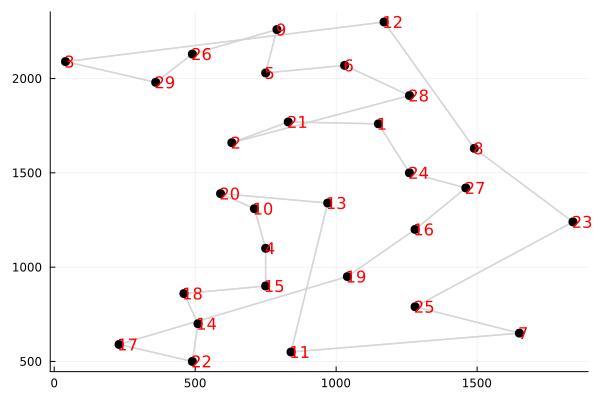

In [101]:
bays_29 = graph_from_tsp("../../instances/stsp/bays29.tsp","graphe")[1]
cycle = rsl(bays_29, nodes(bays_29)[1], "Kruskal")
println("sum of weights ", sum_of_weights(cycle))
plot_graph(cycle)


### Test de RSL sur bays29.tsp avec l'algorithme de Prim

sum of weights 2564.0


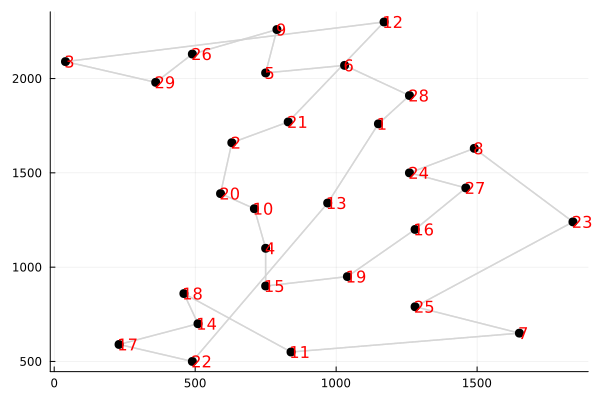

In [102]:
cycle = rsl(bays_29, nodes(bays_29)[1], "Prims")
println("sum of weights ", sum_of_weights(cycle))
plot_graph(cycle)

### Test sur bays29.tsp les paramètres optimaux dans rsl

La meilleure tournée que l'on peut trouver avec RSL est de longueur : 2526.0
Elle est obtenue à l'aide de l'algorithme de Prim avec 9 comme racine.


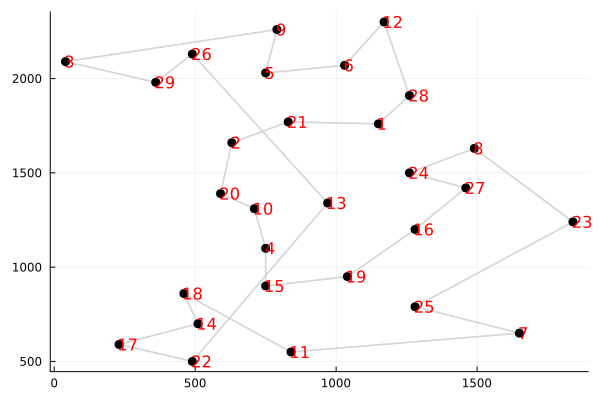

In [103]:
cycle_optimal = optimal_rsl(bays_29)
plot_graph(cycle_optimal)

Ici, on remarque que dans tous les cas, même si la tournée trouvée par RSL n'est pas optimale, sa longueur est toujours inférieure au double de la longueur optimale. C'est ce que la théorie prévoit. En fait, on voit que cette situation est loin d'être le pire cas possible, car le résultat donné par RSL est plutôt près de la valeur optimale de 2020.

La longueur de la tournée trouvée est 1.25 fois la longueur de la tournée optimale.

### Test sur swiss42.tsp de RSL avec Kruskal optimal

Ci-dessous, nous exécutons le RSL sur le graphique swiss42. Veuillez noter que le graphique original n'a pas de coordonnées et que nous avons généré des coordonnées aléatoires. Par conséquent, les distances réelles ne sont pas reflétées dans le graphique.

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓


La meilleure tournée que l'on peut trouver avec RSL est de longueur : 1505.0
Elle est obtenue à l'aide de l'algorithme de Prim avec 39 comme racine.


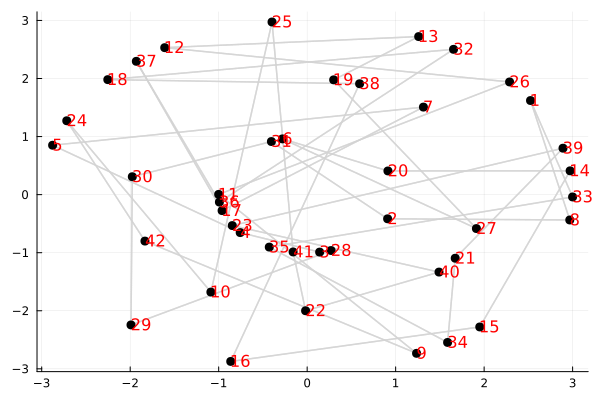

In [104]:
swiss42 = graph_from_tsp("../../instances/stsp/swiss42.tsp","graphe")[1]
cycle = optimal_rsl(swiss42)
plot_graph(cycle)

La longueur de la tournée trouvée est 1.18 fois la longueur de la tournée optimale.

### Test de RSL sur gr17.tsp

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓


La meilleure tournée que l'on peut trouver avec RSL est de longueur : 2152.0
Elle est obtenue à l'aide de l'algorithme de Prim avec 9 comme racine.


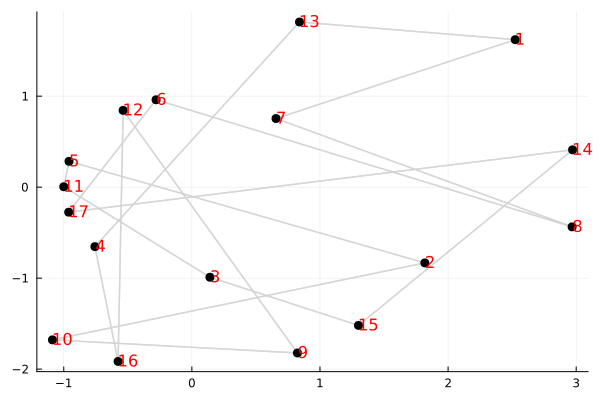

In [105]:
gr17 = graph_from_tsp("../../instances/stsp/gr17.tsp","graphe")[1]
cycle = optimal_rsl(gr17)
plot_graph(cycle)

La longueur de la tournée trouvée est 1.03 fois la longueur de la tournée optimale.

### Test de l'algorithme HK sur gr17 et bays29

Nous testons ici l'algorithme lkh sur la plus petite instance tsp.Nous avons laissé l'algorithme fonctionner pendant une heure et il ne converge pour aucune des stratégies . (nous avons vérifié la norme du vecteur tk pour voir si elle diminuait, mais ce n'est pas le cas/). Voici quelques exemples de ce que cela donne pour 100 000 itérations. Ici "step" est t_k, "time" est la Durée d'une itération, et "VK_norm" est  le nombre de degrés qui nous séparent de v_k = 0.

In [ ]:
gr17_graph, gr17_nodes = graph_from_tsp("../../instances/stsp/gr17.tsp","graphe1")
println("running h_k_algorithm on gr17")
start_node = nodes(gr17_graph)[4]
@time total_distance, one_tree = lkh_subgradient(gr17_graph, t_k_method = "1/k",departure_node=start_node, tree_algorithm = kruskal)


In [ ]:
@time total_distance, one_tree = lkh_subgradient(gr17_graph, t_k_method = "weights/k", tree_algorithm = prims_algorithm)

In [ ]:
@time total_distance, one_tree = lkh_subgradient(gr17_graph, t_k_method = "sqrt", departure_node_selector = random_departure_node_selector)

In [ ]:
@time bays_res = lkh_subgradient(bays_29, t_k_method="weights/k", tree_algorithm= kruskal, departure_node_selector = random_departure_node_selector)

# TSP solver function

Voici une fonction qui accepte en entrée un chemin d'accès au fichier tsp et les solveurs souhaités par l'utilisateur. Par défaut, il exécute la fonction rsl.

In [84]:
function solve_tsp(file_path::String; tsp_method::String = "rsl", start_node_index::Union{Int, Nothing}=nothing, departure_node_selector::Function = random_departure_node_selector, t_k_method::String = "1/k", tree_algorithm::String = "kruskal")
    tsp_graph, tsp_nodes = graph_from_tsp(file_path,"graphe1")
    if isnothing(start_node_index)
        start_node = nodes(tsp_graph)[1]
    else
        start_node = nodes(tsp_graph)[start_node_index]
    end
    if tsp_method == "h_k_algorithm"
        if tree_algorithm =="kruskal"
            println("running h_k_algorithm on ", file_path, " with kruskal")
            @time total_distance, one_tree = lkh_subgradient(tsp_graph, t_k_method = t_k_method, departure_node_selector = departure_node_selector, tree_algorithm = kruskal)
            println(total_distance)
            return total_distance, one_tree
        else
            println("running h_k_algorithm on ", file_path, " with prims")
            @time total_distance, one_tree = lkh_subgradient(tsp_graph, t_k_method = t_k_method, departure_node_selector = departure_node_selector, tree_algorithm = prims_algorithm)
            println(total_distance)
            return total_distance, one_tree
        end
    elseif tsp_method == "rsl"
        if tree_algorithm =="kruskal"
            println("running rsl on ", file_path, " with kruskal")
            @time cycle = rsl(tsp_graph,start_node, "Kruskal")
            println("sum of weights ", sum_of_weights(cycle))
            return sum_of_weights(cycle), cycle
        else
            println("running rsl on ", file_path, " with prims")
            @time cycle = rsl(tsp_graph,start_node, "Prims")
            println("sum of weights ", sum_of_weights(cycle))
            return sum_of_weights(cycle), cycle
        end
    else
        println("Invalid tsp method")
    end
end

solve_tsp (generic function with 1 method)

In [ ]:
solve_tsp("../../instances/stsp/bays29.tsp", tsp_method = "h_k_algorithm", t_k_method="weights/k", tree_algorithm = "prims")

In [85]:
solve_tsp("../../instances/stsp/bays29.tsp", tsp_method = "rsl", tree_algorithm = "kruskal")

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓
running rsl on ../../instances/stsp/bays29.tsp with kruskal
  0.020019 seconds (64.20 k allocations: 2.640 MiB)
sum of weights 2661.0


(2661.0, Graph{Vector{Float64}, Float64}("Cycle", Node{Vector{Float64}}[Node{Vector{Float64}}("1", [1150.0, 1760.0]), Node{Vector{Float64}}("2", [630.0, 1660.0]), Node{Vector{Float64}}("3", [40.0, 2090.0]), Node{Vector{Float64}}("4", [750.0, 1100.0]), Node{Vector{Float64}}("5", [750.0, 2030.0]), Node{Vector{Float64}}("6", [1030.0, 2070.0]), Node{Vector{Float64}}("7", [1650.0, 650.0]), Node{Vector{Float64}}("8", [1490.0, 1630.0]), Node{Vector{Float64}}("9", [790.0, 2260.0]), Node{Vector{Float64}}("10", [710.0, 1310.0])  …  Node{Vector{Float64}}("20", [590.0, 1390.0]), Node{Vector{Float64}}("21", [830.0, 1770.0]), Node{Vector{Float64}}("22", [490.0, 500.0]), Node{Vector{Float64}}("23", [1840.0, 1240.0]), Node{Vector{Float64}}("24", [1260.0, 1500.0]), Node{Vector{Float64}}("25", [1280.0, 790.0]), Node{Vector{Float64}}("26", [490.0, 2130.0]), Node{Vector{Float64}}("27", [1460.0, 1420.0]), Node{Vector{Float64}}("28", [1260.0, 1910.0]), Node{Vector{Float64}}("29", [360.0, 1980.0])], Edge{Flo

## Annexes

### Brute_force_tsp
Nous avons implémenté un algorithme qui génère toutes les permutations possibles et qui trouve la longueur de la tournée optimale dans un graphe donné.

In [ ]:
"""Brute force calculates TSP solution"""
function brute_force_tsp(g::Graph, start_node::Any)
    adjacency_list = adjacency_dict(g)
    g_nodes = nodes(g)
    nodes_perm = collect(permutations(collect(1:length(g_nodes))))
    min_dist = Inf
    min_perm = []
    for perm in nodes_perm
        dist = 0
        for i in 1:length(perm)-1
            dist += adjacency_list[perm[i]][perm[i+1]]
        end
        dist += adjacency_list[perm[end]][perm[1]]
        #println("permutation", perm)
        #println("dist = ", dist)
        if dist < min_dist
            min_dist = dist
            min_perm = perm
        end
        
    end
    return min_dist, min_perm
end